# Section 3.2: FC neural network for classification
## by Telmo Cunha

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

In [2]:
def relu(x):
    return x * (x > 0) # faster than np.max

In [3]:
def relu_derivative(x):
    return (x > 0) * 1

In [4]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

In [5]:
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

In [6]:
def tanh(x):
    return np.tanh(x)

In [7]:
def tanh_derivative(x):
    return 1-np.power(np.tanh(x),2)

In [8]:
def softmax(x):

    x=np.exp(x)
    
    total_sum=np.sum(x,axis=0)  

    d=x/total_sum
    
    return d

In [9]:
def one_hot(Y):
    classes=10
    return np.eye(int(classes))[Y]

In [10]:
def accuracy(Y,Y_hat):

    count=0
    
    z=Y_hat-Y

    for i in z:
        if i==0:
            count+=1
    
    return count/len(z)

In [11]:
def weight_init(neurons,X_train):
    
    n0=X_train.shape[1]
    layers=len(neurons)
    
    W={}

    for i in range(layers):
        if (i==0):
            # normal initialization (+1 for the bias weight)
            W["layer{0}".format(i+1)] = 0.1*np.random.normal(0, 1, (neurons[i],n0+1))
        else:
            # normal initialization (+1 for the bias weight)
            W["layer{0}".format(i+1)] = 0.1*np.random.normal(0, 1, (neurons[i],neurons[i-1]+1))
            
    return W

In [12]:
def loss_function(Z,y_hat):
    
    Z=np.log(Z)
    loss=-np.dot(Z,y_hat)
    
    return loss

In [13]:
def forward_prop(x,W):
    
    # dictionary of layer outputs
    Z = {}
    # dictionary of layer preactivations
    A = {}
    
    if(layers>1):
    
        for i in range(layers-1):
            if (i==0):
                
                A["layer{0}".format(i+1)]=np.dot(W["layer{0}".format(i+1)],x)
                # specify here the activation function
                Z["layer{0}".format(i+1)]=sigmoid(A["layer{0}".format(i+1)])
                
                # insert 1 at the start of each output for the bias
                Z["layer{0}".format(i+1)]=np.insert(Z["layer{0}".format(i+1)],0,1,axis=0)
                #print("output layer",i+1,": ",Z["layer{0}".format(i+1)]) 
            else:
                
                A["layer{0}".format(i+1)]=np.dot(W["layer{0}".format(i+1)],Z["layer{0}".format(i)])
                # specify here the activation function
                Z["layer{0}".format(i+1)]=sigmoid(A["layer{0}".format(i+1)])
    
                # insert 1 at the start of each output for the bias
                Z["layer{0}".format(i+1)]=np.insert(Z["layer{0}".format(i+1)],0,1,axis=0)
                #print("output layer",i+1,": ",Z["layer{0}".format(i+1)]) 
            
        A["layer{0}".format(layers)]=np.dot(W["layer{0}".format(layers)],Z["layer{0}".format(layers-1)])
        Z["layer{0}".format(layers)]=softmax(A["layer{0}".format(layers)])
        #print("output last layer:",Z["layer{0}".format(layers)])  
              
    else:
        print("Vector of neurons badly specified.")
  
    return A,Z

In [14]:
def backprop(x, y, A, Z, W):

    deltas={}
    
    for l in range(layers, 0, -1):
        if (l==layers):
            deltas["layer{0}".format(l)] = Z["layer{0}".format(l)]-y
            deltas["layer{0}".format(l)] = deltas["layer{0}".format(l)].reshape((len(deltas["layer{0}".format(l)]),1))
            #print("delta",deltas["layer{0}".format(l)])
        else:
            a_i=A["layer{0}".format(l)]
            # choose activation function derivative
            h_prime=sigmoid_derivative(a_i).reshape((len(a_i),1))
            aux=np.dot(W["layer{0}".format(l+1)][:,1:].T,deltas["layer{0}".format(l+1)])
            deltas["layer{0}".format(l)] = np.multiply(h_prime,aux)
            #print("delta",deltas["layer{0}".format(l)])
    return deltas

In [15]:
def weight_updates(x,W,A,Z,deltas):
    
    for l in range(1,layers+1):
        if(l==1):
            
            W["layer{0}".format(l)]+=-lrate*np.outer(deltas["layer{0}".format(l)],x)
            
        elif (l==layers):
            
            W["layer{0}".format(l)]+=-lrate*deltas["layer{0}".format(l)]*Z["layer{0}".format(l-1)].T

        else:
            aux1=Z["layer{0}".format(l-1)]        
            aux1=aux1.reshape((1,aux1.shape[0]))               

            W["layer{0}".format(l)]+=-lrate*np.outer(deltas["layer{0}".format(l)],aux1)
            
    return W

In [16]:
def MLP_class_epoch(X_train, Y_train, W):
    
    total_loss = 0
    N=X_train.shape[0]
    
    for n in range(N):
        A,Z = forward_prop(X_train[n,:], W)
        
        # sum loss of example n
        total_loss += loss_function(Z["layer{0}".format(layers)], Y_train[n])
        
        # computing the deltas
        deltas=backprop(X_train[n,:], Y_train[n], A, Z, W)
        
        # updating weights
        W=weight_updates(X_train[n,:],W,A,Z,deltas)

    return total_loss/N

In [17]:
def realization_function(X,W):
    
    N=X.shape[0]
    Y_hat=[]
    
    for n in range(N):
        
        A,Z=forward_prop(X[n,:],W)
        Y_hat.append(np.argmax(Z["layer{0}".format(layers)]))
        
    return Y_hat

# Digit Classification using UCI ML dataset

### Data import and formatting

In [18]:
from sklearn.datasets import load_digits
data = load_digits()

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data.images, data.target, test_size=0.2, random_state=42)

In [20]:
# formatting data
x_datatrain=np.zeros((X_train.shape[0],64))
for j in range(X_train.shape[0]):
    x_datatrain[j]=np.ndarray.flatten(X_train[j])

x_datatest=np.zeros((X_test.shape[0],64))
for j in range(X_test.shape[0]):
    x_datatest[j]=np.ndarray.flatten(X_test[j])

### 1 hidden layer with 50 neurons, lrate=0.001

In [21]:
neurons=[50,10]
layers=len(neurons)

lrate=0.001
max_epochs=100

train_acc = []
test_acc = []
loss= []

# one-hat labels
y_train_onehot=one_hot(Y_train)

# weight init
W=weight_init(neurons,x_datatrain)

# adding bias, X.shape=(1437, 65)
X_train=np.insert(x_datatrain,0,1,axis=1)
X_test=np.insert(x_datatest,0,1,axis=1)

for epoch in range(max_epochs):
    loss.append(MLP_class_epoch(X_train, y_train_onehot, W))
    
    Y_hat_train=realization_function(X_train,W)
    train_acc.append(accuracy(Y_train,Y_hat_train))
    
    Y_hat_test=realization_function(X_test,W)
    test_acc.append(accuracy(Y_test,Y_hat_test))

#### Loss plot

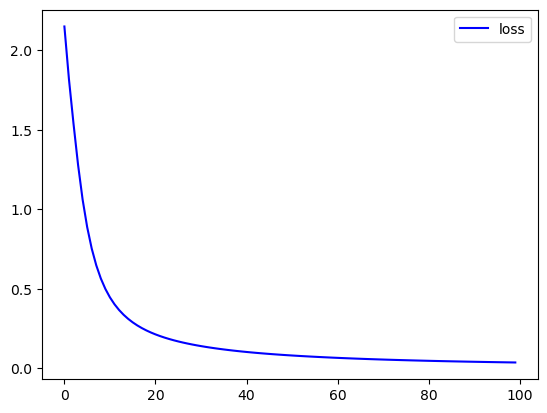

In [22]:
plt.plot(range(max_epochs), loss, 'b-', label='loss')
plt.legend()
plt.show()

#### Train/Test accuracy plots

Train accuracy: 0.9986082115518441
Test accuracy: 0.9722222222222222


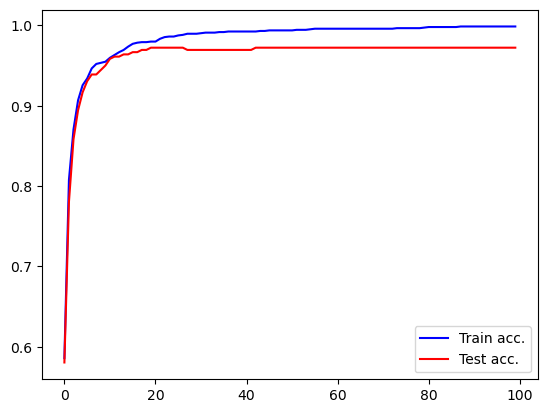

In [23]:
print("Train accuracy:",train_acc[-1])
print("Test accuracy:",test_acc[-1])
plt.plot(range(max_epochs), train_acc, 'b-', label='Train acc.')
plt.plot(range(max_epochs), test_acc, 'r-', label='Test acc.')
plt.legend()
plt.show()

### 3 hidden layers with 30,20,10 neurons, lrate=0.01

In [24]:
neurons=[30,20,10,10]
layers=len(neurons)

lrate=0.01
max_epochs=100

train_acc = []
test_acc = []
loss= []

# one-hat labels
y_train_onehot=one_hot(Y_train)

# weight init
W=weight_init(neurons,x_datatrain)

# adding bias, X.shape=(1437, 65)
X_train=np.insert(x_datatrain,0,1,axis=1)
X_test=np.insert(x_datatest,0,1,axis=1)

for epoch in range(max_epochs):
    loss.append(MLP_class_epoch(X_train, y_train_onehot, W))
    
    Y_hat_train=realization_function(X_train,W)
    train_acc.append(accuracy(Y_train,Y_hat_train))
    
    Y_hat_test=realization_function(X_test,W)
    test_acc.append(accuracy(Y_test,Y_hat_test))

#### Loss function plot

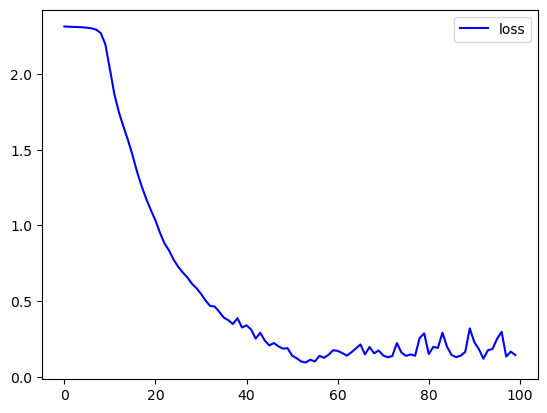

In [25]:
plt.plot(range(max_epochs), loss, 'b-', label='loss')
plt.legend()
plt.show()

#### Train/Test accuracy plots

Train accuracy: 0.9638135003479471
Test accuracy: 0.9138888888888889


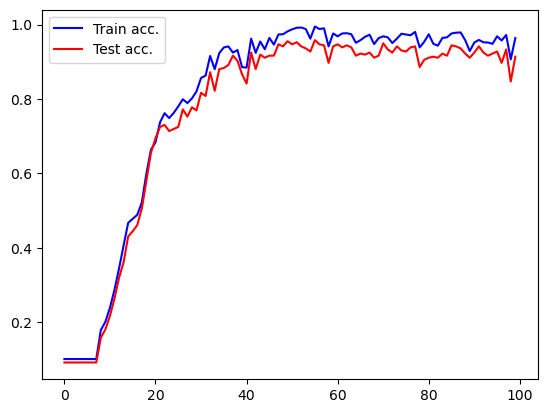

In [26]:
print("Train accuracy:",train_acc[-1])
print("Test accuracy:",test_acc[-1])
plt.plot(range(max_epochs), train_acc, 'b-', label='Train acc.')
plt.plot(range(max_epochs), test_acc, 'r-', label='Test acc.')
plt.legend()
plt.show()